In [1]:
!pip install opencv-python
!pip install tensorflow
!pip install matplotlib
!pip install torchsummary
from torch.utils.data import Dataset
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import transforms as T
from torch import optim
import numpy as np
from PIL import Image
import random
from shapely.geometry.point import Point
from skimage.draw import circle_perimeter_aa
from skimage import draw
from torchsummary import summary

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, input_channel, output_channel):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_channel, output_channel, 3, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(output_channel, output_channel, 3, padding=1),
            nn.BatchNorm2d(output_channel),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)
class Unet(nn.Module):
    def __init__(self,input_channel,output_channel):
        super().__init__()
        self.conv1 = DoubleConv(input_channel, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64,output_channel, 1)

    def forward(self,x):
        c1=self.conv1(x)
        p1=self.pool1(c1)
        c2=self.conv2(p1)
        p2=self.pool2(c2)
        c3=self.conv3(p2)
        up_8=self.up8(c3)
        merged8 = torch.cat([up_8, c2], 1)
        c8=self.conv8(merged8)
        up_9=self.up9(c8)
        merged9=torch.cat([up_9,c1], 1)
        c9=self.conv9(merged9)
        c10=self.conv10(c9)
        output = nn.Sigmoid()(c10)
        return output


In [3]:
def draw_circle(img, row, col, rad):
    rr, cc, val = circle_perimeter_aa(row, col, rad)
    valid = (
        (rr >= 0) &
        (rr < img.shape[0]) &
        (cc >= 0) &
        (cc < img.shape[1])
    )
    img[rr[valid], cc[valid]] = val[valid]


def noisy_circle(size, radius, noise):
    img = np.zeros((size, size), dtype=np.float)

    # Circle
    row = np.random.randint(size)
    col = np.random.randint(size)
    rad = np.random.randint(10, max(10, radius))
    draw_circle(img, row, col, rad)

    # Noise
    img += noise * np.random.rand(*img.shape)
    return (row, col, rad), img

def iou(params0, params1):
    row0, col0, rad0 = params0
    row1, col1, rad1 = params1

    shape0 = Point(row0, col0).buffer(rad0)
    shape1 = Point(row1, col1).buffer(rad1)

    return (
        shape0.intersection(shape1).area /
        shape0.union(shape1).area
    )


In [4]:
def generate_masks(size):
    masks = []
    imgs = []
    for i in range(size):
        params, img = noisy_circle(200, 50, 2)
        imgs.append(img)
        arr = np.zeros((200, 200))
        for i in range(params[2]+1):
            rr, cc = draw.circle_perimeter(params[0], params[1], i,method='andres', shape=arr.shape)
            arr[rr, cc] = 1
        masks.append(arr)
    return imgs, masks
class circleDataset(Dataset):
    def __init__(self,size,transform = None):
        imgs, masks = generate_masks(size)
        self.size = size
        self.imgs = imgs
        self.masks = masks
        self.transform = transform
    def __getitem__(self, index):
        img = self.imgs[index]
        mask = self.masks[index]*255
        img = Image.fromarray(np.uint8(img))
        mask = Image.fromarray(np.uint8(mask))
        if self.transform is not None:
            img = self.transform(img)
            mask = self.transform(mask)
        return img, mask

    def __len__(self):
        return self.size

In [5]:
transform = T.Compose([
    T.ToTensor()
])
circle_dataset = circleDataset(10,transform)


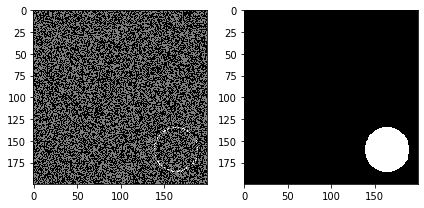

In [6]:
x, y = circle_dataset.__getitem__(2)
plt.subplot(1,2,1)
plt.imshow(x.squeeze(),cmap="gray")
plt.subplot(1,2,2)
plt.imshow(y.squeeze(),cmap="gray")
plt.tight_layout()
plt.savefig('image_new1.jpg',dpi=1200)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Unet(1,1).to(device)
criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters())

def dice_loss(image,label):
    product = image.view(-1)*label.view(-1)
    intersection = torch.sum(product)
    coefficient = (2.*intersection +1.) / (torch.sum(image*image)+torch.sum(label*label) +1.)
    loss = 1. - coefficient
    return loss
def iou_loss(image,label):
    product = image.view(-1)*label.view(-1)
    intersection = torch.sum(product)
    iou = (intersection + 1.)/(torch.sum(image*image)+torch.sum(label*label)-intersection + 1.)
    return 1.-iou

def train_model(model,num_epoch,criterion,optimizer,dataloader,weight):
    best_sdc_score = 0
    print("start training")
    count = 0
    for epoch in range(num_epoch):
        running_loss = 0
        sdc = 0
        for imgs, labels in dataloader:
            count = count+1
            optimizer.zero_grad()
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            sdc += (1. - dice_loss(outputs, labels))
        if sdc/len(dataloader) > best_sdc_score:
            best_sdc_score = sdc/len(dataloader)
            torch.save(model.state_dict(),weight)
        print("Epoch: {}/{}".format(epoch+1, num_epoch),
              "Training Loss: {:.3f}".format(running_loss/len(dataloader)))


In [ ]:
summary(model,input_size=(1,208,208))

In [ ]:
print(model)

In [6]:
transform = T.Compose([
    T.ToTensor()
])
circle_dataset_train = circleDataset(2000,transform)
dataloader_train = DataLoader(circle_dataset_train,4)

In [7]:
model.train()
train_model(model,10,iou_loss,optimizer,dataloader_train,'weights_q2_6.pth')

start training
Epoch: 1/10 Training Loss: 0.317
Epoch: 2/10 Training Loss: 0.170
Epoch: 3/10 Training Loss: 0.147
Epoch: 4/10 Training Loss: 0.138
Epoch: 5/10 Training Loss: 0.137
Epoch: 6/10 Training Loss: 0.133
Epoch: 7/10 Training Loss: 0.125
Epoch: 8/10 Training Loss: 0.118
Epoch: 9/10 Training Loss: 0.113
Epoch: 10/10 Training Loss: 0.106


In [8]:
#ignore this part, the actual test part in test_performance below
def test_model(model,dataloader):
    with torch.no_grad():
        sdc = 0
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            result.append((labels,outputs,imgs))
            sdc += (1. - dice_loss(outputs, labels))
        print("Sørensen–Dice coefficient: {:.3f}".format(sdc/len(dataloader)))

In [9]:
transform = T.Compose([
    T.ToTensor()
])
circle_dataset_test = circleDataset(1000,transform)

In [10]:
model.load_state_dict(torch.load('weights_q2_6.pth'))
dataloader_test = DataLoader(circle_dataset_test)
result = []
test_model(model,dataloader_test)

Sørensen–Dice coefficient: 0.937


torch.Size([200, 200])


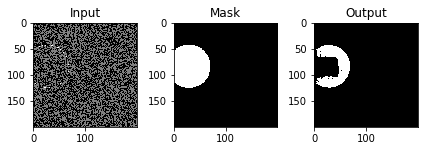

In [14]:
def show_output(result,index):
    print(result[index][0].cpu().squeeze().shape)
    plt.subplot(1,3,2)
    plt.imshow(result[index][0].cpu().squeeze(),cmap="gray")
    plt.title('Mask')
    plt.subplot(1,3,3)
    res = np.round(np.array(result[index][1].cpu().squeeze()),5)
    res = res > 0.999
    plt.imshow(res,cmap="gray")
    plt.title('Output')
    plt.subplot(1,3,1)
    plt.imshow(result[index][2].cpu().squeeze(),cmap="gray")
    plt.title("Input")
    plt.tight_layout()
    plt.savefig('image_new1.jpg',dpi=1200)
show_output(result,15)

Text(0.5, 1.0, 'Input')

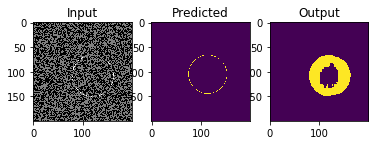

In [439]:
# ignore this part for testing purpose
res = np.round(np.array(result[0][1].cpu().squeeze()),5)
res = res > 0.999
plt.subplot(1,3,3)
plt.imshow(res)
plt.title('Output')
x = np.where(res == 1)

candidate_points = []
for i in range(len(x[0])):
    candidate_points.append((x[0][i],x[1][i]))
row_sorted = sorted(candidate_points)
col_sorted = sorted(candidate_points,key=lambda x: x[1])
min_y = row_sorted[0]
max_y = row_sorted[-1]
min_x = col_sorted[0]
max_x = col_sorted[-1]

y_vertex = row_sorted[0]
y_top = 1
x_vertex = col_sorted[0]
x_left = 1

if y_vertex[0] == 0: 
    y_top = 0
    y_vertex = row_sorted[-1]
if x_vertex[1] == 0:
    x_left = 1
    x_vertex = col_sorted[-1]
    
radius = int(abs(y_vertex[0] - x_vertex[0]))
row = x_vertex[0]
col = y_vertex[1]
arr = np.zeros((200, 200))
rr, cc = draw.circle_perimeter(row, col,radius, shape=arr.shape)
arr[rr, cc] = 1
plt.subplot(1,3,2)
plt.imshow(arr)
plt.title("Predicted")

plt.subplot(1,3,1)
plt.imshow(result[0][2].cpu().squeeze(),cmap="gray")
plt.title("Input")


In [28]:
def find_circle(img):
    model = Unet(1,1).to(device)
    model.load_state_dict(torch.load('weights_q2_6.pth'))
    with torch.no_grad():
        transform = T.Compose([
            T.ToTensor()
        ])
        img = Image.fromarray(np.uint8(img))
        res = model(transform(img).unsqueeze(0).to(device))
        res = np.round(np.array(res.cpu().squeeze()),5)
        res = res > 0.999
        x = np.where(res == 1)
        candidate_points = []
        for i in range(len(x[0])):
            candidate_points.append((x[0][i],x[1][i]))
        row_sorted = sorted(candidate_points)
        col_sorted = sorted(candidate_points,key=lambda x: x[1])
        y_vertex = row_sorted[0]
        x_vertex = col_sorted[0]
        
        if y_vertex[0] == 0:
            y_vertex = row_sorted[-1]
        if x_vertex[1] == 0: 
            x_vertex = col_sorted[-1]

        radius = int(abs(y_vertex[0] - x_vertex[0]))+3
        row = x_vertex[0]+3
        col = y_vertex[1]+3
        
    return row, col, radius

In [17]:
def draw_circle_(img,detected,params):
    img = img/img.max()*255
    img = np.dstack([img,img,img]).astype(np.uint8)
    rr, cc = draw.circle_perimeter(detected[0],detected[1],detected[2], shape=arr.shape)
    draw.set_color(img,(rr,cc),(255,0,0))
    rr1, cc1 = draw.circle_perimeter(params[0],params[1],params[2], shape=arr.shape)
    draw.set_color(img,(rr1,cc1),(0,255,0))
    plt.imshow(img)

In [647]:
params, img = noisy_circle(200, 50, 2)

IOU is : 1.0


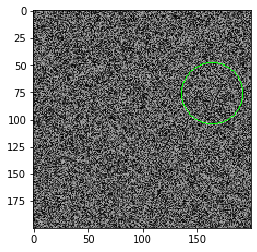

In [648]:
detected = find_circle(img)
draw_circle_(img,detected,params)
print("IOU is :",iou(params, detected))

In [45]:
def test_performance():
    results = []
    for _ in range(1000):
        params, img = noisy_circle(200, 50, 2)
        detected = find_circle(img)
        results.append(iou(params, detected))
    results = np.array(results)
    print((results > 0.7).mean()) 
test_performance()

0.79
